types of equations you can expect to get solved...

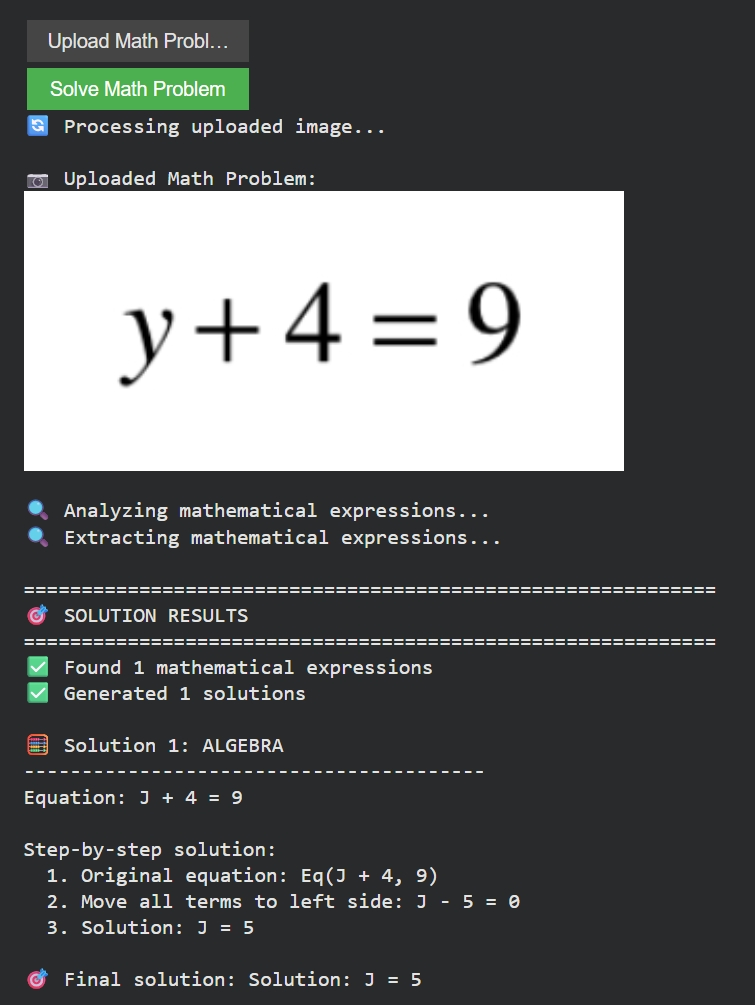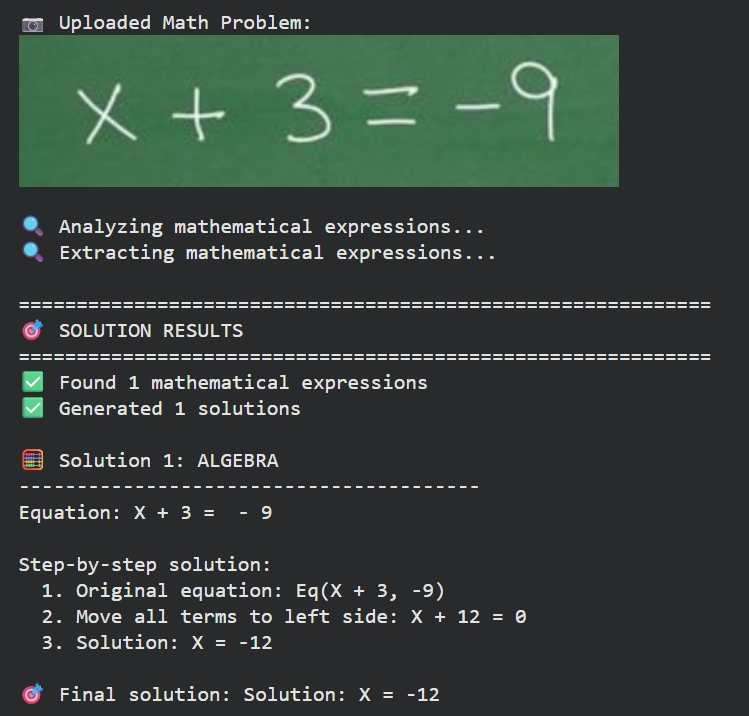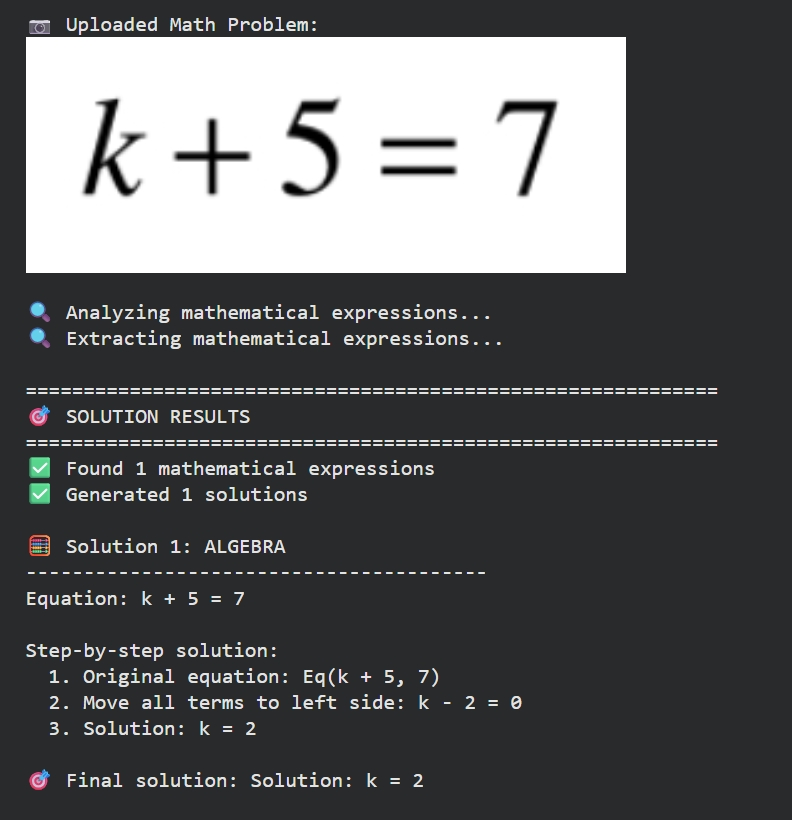

In [ ]:
!pip install torch torchvision transformers
!pip install opencv-python pillow
!pip install easyocr pytesseract
!pip install sympy numpy scipy
!pip install matplotlib
!pip install scikit-learn
!pip install transformers datasets
!pip install ipywidgets
!pip install Ipython


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import easyocr
import pytesseract
import sympy as sp
from sympy import symbols, solve, integrate, diff, limit, series, plot, latex
import matplotlib.pyplot as plt
import re
import json
from typing import Dict, List, Tuple, Any, Optional
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

Probabilistic OCR for Mathematical Expressions...

In [3]:
class MathExpressionOCR:
    def __init__(self):
        self.reader = easyocr.Reader(['en'])
        self.math_symbols = {
            'integral': ['∫', 'integral'],
            'derivative': ['d/dx', 'derivative', '∂'],
            'limit': ['lim', 'limit'],
            'sum': ['∑', 'sum'],
            'product': ['∏', 'product'],
            'sqrt': ['√', 'sqrt'],
            'pi': ['π', 'pi'],
            'infinity': ['∞', 'infinity']
        }

    def extract_math_expressions(self, image: np.ndarray) -> List[Dict]:
        """Extract mathematical expressions from image with confidence scores"""
        # Preprocess for better OCR
        processed_img = self._preprocess_image(image)

        # Get OCR results
        results = self.reader.readtext(processed_img, detail=1)

        math_expressions = []
        for (bbox, text, confidence) in results:
            # Clean and parse mathematical text
            cleaned_text = self._clean_math_text(text)
            expression_type = self._classify_expression(cleaned_text)

            parsed_expr = self._parse_expression(cleaned_text)
            math_expressions.append({
                'original_text': text,
                'cleaned_text': cleaned_text,
                'type': expression_type,
                'parsed_components': parsed_expr,
                'confidence': confidence,
                'bbox': bbox
            })

        return sorted(math_expressions, key=lambda x: x['confidence'], reverse=True)

    def _preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Preprocess image to improve OCR accuracy for math symbols"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        # Enhance contrast
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        enhanced = clahe.apply(gray)

        # Denoise
        denoised = cv2.medianBlur(enhanced, 3)

        return denoised

    def _clean_math_text(self, text: str) -> str:
        """Clean and normalize mathematical text"""
        # Common OCR corrections
        corrections = {
            'O': '0', 'o': '0', 'l': '1', 'I': '1',
            'Z': '2', 'S': '5', 'B': '8',
            '—': '-', '–': '-', '−': '-',
            '×': '*', '÷': '/', '∗': '*',
            '（': '(', '）': ')', '【': '[', '】': ']',
            '‘': "'", '`': "'"
        }

        cleaned = text
        for wrong, correct in corrections.items():
            cleaned = cleaned.replace(wrong, correct)

        # Remove extra spaces around operators
        cleaned = re.sub(r'\s*([+\-*/=^<>])\s*', r' \1 ', cleaned)

        return cleaned.strip()

    def _classify_expression(self, text: str) -> str:
        """Classify the type of mathematical expression"""
        text_lower = text.lower()

        # Check for calculus expressions
        if any(symbol in text_lower for symbol in ['∫', 'integral', 'd/dx', 'derivative', '∂']):
            return 'calculus'
        elif any(symbol in text_lower for symbol in ['lim', 'limit']):
            return 'limit'
        elif any(symbol in text_lower for symbol in ['∑', 'sum', '∏', 'product']):
            return 'series'
        elif '=' in text:
            return 'equation'
        elif any(op in text for op in ['+', '-', '*', '/', '^']) and self._is_arithmetic(text):
            return 'arithmetic'
        elif any(op in text for op in ['+', '-', '*', '/', '^']):
            return 'expression'
        else:
            return 'unknown'

    def _is_arithmetic(self, text: str) -> bool:
        """Check if expression is purely arithmetic (no variables)"""
        # Remove spaces and check if it contains only numbers and operators
        clean_text = re.sub(r'\s+', '', text)
        arithmetic_pattern = r'^[\d+\-*/().^]+$'
        return bool(re.match(arithmetic_pattern, clean_text))

    def _parse_expression(self, text: str) -> Dict:
        """Parse mathematical expression into components"""
        components = {
            'variables': [],
            'constants': [],
            'operators': [],
            'functions': [],
            'is_arithmetic': self._is_arithmetic(text)
        }

        # Extract variables (single letters, possibly with subscripts)
        variables = re.findall(r'\b[a-zA-Z]_{0,1}[a-zA-Z0-9]*\b', text)
        components['variables'] = list(set(variables))

        # Extract constants (numbers)
        constants = re.findall(r'\b\d+\.?\d*\b', text)
        components['constants'] = constants

        # Extract operators
        operators = re.findall(r'[+\-*/=^<>]', text)
        components['operators'] = operators

        # Extract functions
        functions = re.findall(r'\b(sin|cos|tan|log|ln|exp|sqrt)\b', text.lower())
        components['functions'] = functions

        return components

Arithemetic Probelm Solver...

In [4]:
class ArithmeticSolver:
    def __init__(self):
        self.operation_symbols = {
            '+': 'addition',
            '-': 'subtraction',
            '*': 'multiplication',
            '/': 'division',
            '^': 'exponentiation'
        }

    def solve_arithmetic(self, expression_text: str) -> Dict:
        """Solve arithmetic expression with step-by-step explanation"""
        try:
            steps = []

            # Clean the expression
            cleaned_expr = self._clean_expression(expression_text)
            steps.append(f"Original expression: {expression_text}")
            steps.append(f"Cleaned expression: {cleaned_expr}")

            # Parse and evaluate step by step
            result = self._evaluate_with_steps(cleaned_expr, steps)

            return {
                'type': 'arithmetic',
                'expression': expression_text,
                'cleaned_expression': cleaned_expr,
                'steps': steps,
                'result': result
            }

        except Exception as e:
            return {'error': f'Arithmetic solution error: {str(e)}'}

    def _clean_expression(self, expression: str) -> str:
        """Clean arithmetic expression for evaluation"""
        # Remove spaces
        cleaned = expression.replace(' ', '')

        # Replace multiplication symbols
        cleaned = cleaned.replace('×', '*').replace('·', '*')

        # Replace division symbols
        cleaned = cleaned.replace('÷', '/')

        # Ensure proper operator spacing for readability (optional)
        cleaned = re.sub(r'([+\-*/^])', r' \1 ', cleaned)

        return cleaned.strip()

    def _evaluate_with_steps(self, expression: str, steps: List[str]) -> float:
        """Evaluate arithmetic expression with step-by-step explanation"""
        try:
            # Remove spaces for evaluation
            eval_expr = expression.replace(' ', '')

            # Handle parentheses first
            while '(' in eval_expr:
                start = eval_expr.rfind('(')
                end = eval_expr.find(')', start)
                if end == -1:
                    raise ValueError("Mismatched parentheses")

                sub_expr = eval_expr[start+1:end]
                sub_result = self._evaluate_simple_expression(sub_expr)

                steps.append(f"Evaluate parentheses: ({sub_expr}) = {sub_result}")
                eval_expr = eval_expr[:start] + str(sub_result) + eval_expr[end+1:]

            # Evaluate the remaining expression
            final_result = self._evaluate_simple_expression(eval_expr)
            steps.append(f"Final evaluation: {eval_expr} = {final_result}")

            return final_result

        except Exception as e:
            steps.append(f"Evaluation error: {str(e)}")
            raise

    def _evaluate_simple_expression(self, expression: str) -> float:
        """Evaluate expression without parentheses"""
        # Handle exponentiation first
        if '^' in expression:
            return self._evaluate_with_operator(expression, '^', self._power, "exponentiation")

        # Handle multiplication and division
        if '*' in expression or '/' in expression:
            # Handle multiplication
            if '*' in expression:
                expression = self._evaluate_with_operator(expression, '*', self._multiply, "multiplication")
            # Handle division
            if '/' in expression:
                expression = self._evaluate_with_operator(expression, '/', self._divide, "division")
            return float(expression)

        # Handle addition and subtraction
        if '+' in expression or '-' in expression:
            # Handle addition
            if '+' in expression:
                expression = self._evaluate_with_operator(expression, '+', self._add, "addition")
            # Handle subtraction (check for negative numbers)
            if '-' in expression and not expression.startswith('-'):
                # Find the first subtraction that's not at the beginning
                parts = expression.split('-', 1)
                if len(parts) == 2:
                    left = float(parts[0])
                    right = float(parts[1])
                    result = left - right
                    return result
            return float(expression)

        return float(expression)

    def _evaluate_with_operator(self, expression: str, operator: str,
                              operation_func, operation_name: str) -> str:
        """Evaluate expression for a specific operator"""
        parts = expression.split(operator)
        if len(parts) < 2:
            return expression

        left = float(parts[0])
        right = float(parts[1])
        result = operation_func(left, right)

        # Rebuild expression with result
        new_expression = str(result) + ''.join(parts[2:])
        return new_expression

    def _add(self, a: float, b: float) -> float:
        return a + b

    def _subtract(self, a: float, b: float) -> float:
        return a - b

    def _multiply(self, a: float, b: float) -> float:
        return a * b

    def _divide(self, a: float, b: float) -> float:
        if b == 0:
            raise ValueError("Division by zero")
        return a / b

    def _power(self, a: float, b: float) -> float:
        return a ** b

    def solve_arithmetic_chain(self, expressions: List[str]) -> Dict:
        """Solve multiple arithmetic expressions in sequence"""
        steps = []
        results = []

        for i, expr in enumerate(expressions, 1):
            steps.append(f"Problem {i}: {expr}")
            solution = self.solve_arithmetic(expr)

            if 'error' not in solution:
                steps.extend([f"  {step}" for step in solution['steps']])
                results.append(solution['result'])
                steps.append(f"  Result: {solution['result']}")
            else:
                steps.append(f"  Error: {solution['error']}")
                results.append(None)

        return {
            'type': 'arithmetic_chain',
            'expressions': expressions,
            'steps': steps,
            'results': results
        }

Algebra Equation Solver...

In [5]:
class AlgebraicSolver:
    def __init__(self):
        self.symbols_cache = {}

    def solve_equation(self, equation_text: str) -> Dict:
        """Solve algebraic equation and return step-by-step solution"""
        try:
            # Parse equation
            parsed_eq = self._parse_equation(equation_text)
            if not parsed_eq:
                return {'error': 'Could not parse equation'}

            lhs, rhs = parsed_eq

            # Get variables
            variables = self._extract_variables(equation_text)
            if not variables:
                return {'error': 'No variables found in equation'}

            # Solve step by step
            solution_steps = self._generate_solution_steps(lhs, rhs, variables[0])

            return {
                'type': 'algebra',
                'equation': equation_text,
                'variables': variables,
                'steps': solution_steps,
                'final_solution': solution_steps[-1] if solution_steps else 'No solution found'
            }

        except Exception as e:
            return {'error': f'Solution error: {str(e)}'}

    def _parse_equation(self, equation_text: str) -> Tuple[Any, Any]:
        """Parse equation string into SymPy expressions"""
        try:
            # Clean the equation
            cleaned = equation_text.replace('^', '**').replace(' ', '')

            if '=' not in cleaned:
                return None

            lhs_str, rhs_str = cleaned.split('=', 1)

            # Parse both sides
            lhs = sp.sympify(lhs_str)
            rhs = sp.sympify(rhs_str)

            return lhs, rhs

        except Exception as e:
            print(f"Parsing error: {e}")
            return None

    def _extract_variables(self, text: str) -> List[str]:
        """Extract mathematical variables from text"""
        # Find single letter variables (excluding mathematical constants)
        math_constants = ['e', 'pi', 'π']
        variables = re.findall(r'\b[a-zA-Z]\b', text)

        # Filter out constants and duplicates
        filtered_vars = [v for v in variables if v.lower() not in math_constants]
        return list(set(filtered_vars))

    def _generate_solution_steps(self, lhs, rhs, variable: str) -> List[str]:
        """Generate step-by-step solution for algebraic equation"""
        steps = []
        var_sym = symbols(variable)

        # Step 1: Original equation
        steps.append(f"Original equation: {sp.Eq(lhs, rhs)}")

        # Step 2: Move all terms to left side
        equation = lhs - rhs
        steps.append(f"Move all terms to left side: {equation} = 0")

        # Step 3: Simplify
        simplified = sp.simplify(equation)
        if simplified != equation:
            steps.append(f"Simplify: {simplified} = 0")

        # Step 4: Solve
        try:
            solutions = sp.solve(simplified, var_sym)
            if solutions:
                if len(solutions) == 1:
                    steps.append(f"Solution: {variable} = {solutions[0]}")
                else:
                    steps.append(f"Solutions: {variable} = {solutions}")
            else:
                steps.append("No solution found")
        except Exception as e:
            steps.append(f"Error solving equation: {str(e)}")

        return steps

Calculus Problem Solver...

In [6]:
class CalculusSolver:
    def __init__(self):
        self.differentiation_rules = {
            'power': "d/dx(x^n) = n*x^(n-1)",
            'product': "d/dx(uv) = u'v + uv'",
            'quotient': "d/dx(u/v) = (u'v - uv')/v^2",
            'chain': "d/dx(f(g(x))) = f'(g(x)) * g'(x)"
        }

    def solve_derivative(self, expression_text: str, variable: str = 'x') -> Dict:
        """Solve derivative problem with step-by-step explanation"""
        try:
            steps = []

            # Parse expression
            expr = self._parse_expression(expression_text, variable)
            if expr is None:
                return {'error': 'Could not parse expression'}

            steps.append(f"Find derivative of: {expr} with respect to {variable}")

            # Apply differentiation rules
            derivative = self._differentiate_with_steps(expr, variable, steps)

            # Final result
            steps.append(f"Final derivative: {derivative}")

            return {
                'type': 'derivative',
                'expression': expression_text,
                'variable': variable,
                'steps': steps,
                'result': str(derivative)
            }

        except Exception as e:
            return {'error': f'Derivative error: {str(e)}'}

    def solve_integral(self, expression_text: str, variable: str = 'x',
                      limits: Tuple[Optional[float], Optional[float]] = (None, None)) -> Dict:
        """Solve integral problem"""
        try:
            steps = []

            # Parse expression
            expr = self._parse_expression(expression_text, variable)
            if expr is None:
                return {'error': 'Could not parse expression'}

            if limits[0] is not None and limits[1] is not None:
                steps.append(f"Evaluate definite integral: ∫ from {limits[0]} to {limits[1]} of {expr} d{variable}")
                result = sp.integrate(expr, (symbols(variable), limits[0], limits[1]))
                steps.append(f"Result: {result}")
            else:
                steps.append(f"Find indefinite integral: ∫ {expr} d{variable}")
                result = sp.integrate(expr, symbols(variable))
                steps.append(f"Result: {result} + C")

            return {
                'type': 'integral',
                'expression': expression_text,
                'variable': variable,
                'steps': steps,
                'result': str(result)
            }

        except Exception as e:
            return {'error': f'Integral error: {str(e)}'}

    def _parse_expression(self, expression_text: str, variable: str) -> Any:
        """Parse mathematical expression"""
        try:
            cleaned = expression_text.replace('^', '**').replace(' ', '')
            return sp.sympify(cleaned)
        except:
            return None

    def _differentiate_with_steps(self, expr, variable: str, steps: List[str]) -> Any:
        """Differentiate with step-by-step explanation"""
        var_sym = symbols(variable)

        # Check for specific rules
        if expr.is_Pow:
            base, exponent = expr.as_base_exp()
            steps.append(f"Apply power rule: d/dx({base}^{exponent}) = {exponent}*{base}^({exponent}-1)")

        elif expr.is_Mul:
            factors = expr.args
            if len(factors) == 2:
                u, v = factors
                steps.append(f"Apply product rule: d/dx(uv) = u'v + uv'")
                steps.append(f"Where u = {u}, v = {v}")

        elif expr.is_Add:
            terms = expr.args
            steps.append("Apply sum rule: derivative of sum is sum of derivatives")

        # Compute derivative
        derivative = sp.diff(expr, var_sym)

        # Show simplified result if different
        simplified = sp.simplify(derivative)
        if simplified != derivative:
            steps.append(f"Derivative: {derivative}")
            steps.append(f"Simplified: {simplified}")
            return simplified
        else:
            steps.append(f"Derivative: {derivative}")
            return derivative

Mathematical Reasoning Engine

In [7]:
class MathProblemEngine:
    def __init__(self):
        self.ocr = MathExpressionOCR()
        self.arithmetic_solver = ArithmeticSolver()
        self.algebra_solver = AlgebraicSolver()
        self.calculus_solver = CalculusSolver()

    def process_image(self, image_path: str) -> Dict:
        """Process math problem image and generate solution"""
        try:
            # Load image
            image = self._load_image(image_path)
            if image is None:
                return {'error': 'Could not load image'}

            # Extract mathematical expressions
            print("🔍 Extracting mathematical expressions...")
            expressions = self.ocr.extract_math_expressions(image)

            if not expressions:
                return {'error': 'No mathematical expressions found in image'}

            # Classify and solve problems
            solutions = []
            for expr in expressions:
                solution = self._solve_expression(expr)
                if solution and 'error' not in solution:
                    solutions.append(solution)

            if not solutions:
                return {'error': 'Could not solve any expressions'}

            return {
                'success': True,
                'expressions_found': len(expressions),
                'solutions': solutions,
                'best_solution': solutions[0]  # Highest confidence solution
            }

        except Exception as e:
            return {'error': f'Processing error: {str(e)}'}

    def _load_image(self, image_path: str) -> Optional[np.ndarray]:
        """Load image from file path"""
        try:
            image = cv2.imread(image_path)
            return image
        except:
            return None

    def _solve_expression(self, expression_data: Dict) -> Dict:
        """Solve individual mathematical expression"""
        expr_type = expression_data['type']
        text = expression_data['cleaned_text']
        parsed_components = expression_data['parsed_components']

        # Handle arithmetic problems
        if expr_type == 'arithmetic' or parsed_components['is_arithmetic']:
            return self.arithmetic_solver.solve_arithmetic(text)

        # Handle algebra equations
        elif expr_type == 'equation':
            return self.algebra_solver.solve_equation(text)

        # Handle calculus problems
        elif expr_type == 'calculus':
            # Try to identify specific calculus type
            if '∫' in text or 'integral' in text.lower():
                return self.calculus_solver.solve_integral(self._extract_integrand(text))
            elif 'd/d' in text.lower() or 'derivative' in text.lower():
                return self.calculus_solver.solve_derivative(self._extract_function(text))
            elif 'lim' in text.lower():
                return self.calculus_solver.solve_limit(self._extract_limit_expression(text))

        # Try arithmetic for simple expressions
        elif expr_type == 'expression' and parsed_components['is_arithmetic']:
            return self.arithmetic_solver.solve_arithmetic(text)

        # Try algebra for expressions with variables
        elif expr_type == 'expression' and parsed_components['variables']:
            return self.algebra_solver.solve_equation(text + " = 0")

        return {'error': f'Unsupported expression type: {expr_type}'}

    def _extract_integrand(self, text: str) -> str:
        """Extract integrand from integral expression"""
        if '∫' in text:
            parts = text.split('∫')
            if len(parts) > 1:
                return parts[1].split('d')[0].strip()
        return text.replace('integral', '').replace('∫', '').strip()

    def _extract_function(self, text: str) -> str:
        """Extract function from derivative expression"""
        if 'd/d' in text:
            parts = text.split('d/d')
            if len(parts) > 1:
                return parts[1].split(' ')[-1]
        return text.replace('derivative', '').replace('d/dx', '').strip()

    def _extract_limit_expression(self, text: str) -> str:
        """Extract expression from limit notation"""
        if 'lim' in text:
            return text.split(')')[-1].strip()
        return text

Interactive Testing Interface...

In [ ]:
class MathProblemTester:
    def __init__(self):
        self.engine = MathProblemEngine()
        self.setup_ui()

    def setup_ui(self):
        """Setup the image upload interface"""
        self.upload = widgets.FileUpload(
            accept='image/*',
            multiple=False,
            description='Upload Math Problem'
        )

        self.process_btn = widgets.Button(
            description='Solve Math Problem',
            button_style='success',
            tooltip='Click to solve the uploaded math problem'
        )

        self.output = widgets.Output()

        self.process_btn.on_click(self.process_image)

        # Display UI
        display(widgets.VBox([
            widgets.HTML("<h2>Math Problem Solver - Algebra, Calculus & Arithmetic</h2>"),
            widgets.HTML("<p>Upload an image of a math problem (arithmetic, algebra, or calculus)</p>"),
            self.upload,
            self.process_btn,
            self.output
        ]))

    def save_uploaded_image(self, uploaded_file):
        """Save uploaded image to temporary file"""
        uploaded_content = list(uploaded_file.values())[0]['content']
        temp_path = "temp_math_image.png"
        with open(temp_path, 'wb') as f:
            f.write(uploaded_content)
        return temp_path

    def display_image(self, image_path):
        """Display the uploaded image"""
        from IPython.display import Image, display
        display(Image(filename=image_path, width=400))

    def process_image(self, btn):
        """Process the uploaded image"""
        with self.output:
            clear_output()

            if not self.upload.value:
                print("❌ upload an image first!")
                return

            try:
                print("🔄 Processing uploaded image...")

                # Save uploaded image
                temp_path = self.save_uploaded_image(self.upload.value)

                # Display the uploaded image
                print("\n📷 Uploaded Math Problem:")
                self.display_image(temp_path)

                # Process with engine
                print("\n🔍 Analyzing mathematical expressions...")
                result = self.engine.process_image(temp_path)

                # Display results
                self.display_results(result)

                # Clean up
                os.remove(temp_path)

            except Exception as e:
                print(f"❌ Error processing image: {str(e)}")

    def display_results(self, result):
        """Display the solution results"""
        print("\n" + "="*60)
        print("🎯 SOLUTION RESULTS")
        print("="*60)

        if 'error' in result:
            print(f"❌ {result['error']}")
            return

        print(f"✅ Found {result['expressions_found']} mathematical expressions")
        print(f"✅ Generated {len(result['solutions'])} solutions")

        for i, solution in enumerate(result['solutions'], 1):
            print(f"\n🧮 Solution {i}: {solution.get('type', 'unknown').upper()}")
            print("-" * 40)

            if 'equation' in solution:
                print(f"Equation: {solution['equation']}")
            elif 'expression' in solution:
                print(f"Expression: {solution['expression']}")

            print("\nStep-by-step solution:")
            steps = solution.get('steps', [])
            if steps:
                for j, step in enumerate(steps, 1):
                    print(f"  {j}. {step}")
            else:
                print("  No steps available")

            if 'result' in solution:
                print(f"\n🎯 Final result: {solution['result']}")
            elif 'final_solution' in solution:
                print(f"\n🎯 Final solution: {solution['final_solution']}")

        # Show best solution prominently
        best = result.get('best_solution', {})
        if best:
            print("\n" + "⭐" * 10)
            print("⭐ BEST SOLUTION ⭐")
            print("⭐" * 10)
            print(f"Type: {best.get('type', 'unknown').upper()}")
            steps = best.get('steps', [])
            if steps:
                for step in steps[-3:]:  # Show last 3 steps
                    print(f"  → {step}")

# Direct testing function for your own files
def test_math_problem(image_path: str):
    """
    Test the math engine with your own image file

    Args:
        image_path (str): Path to your math problem image
    """
    engine = MathProblemEngine()

    print(f"🔄 Processing your image: {image_path}")
    print("="*50)

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        print("Please make sure the file path is correct")
        return

    # Display image
    from IPython.display import Image, display
    display(Image(filename=image_path, width=400))

    # Process image
    result = engine.process_image(image_path)

    # Display results
    if 'error' in result:
        print(f"❌ Error: {result['error']}")
        return

    print(f"✅ Successfully processed your image!")
    print(f"📊 Expressions found: {result['expressions_found']}")
    print(f"🎯 Solutions generated: {len(result['solutions'])}")

    for i, solution in enumerate(result['solutions'], 1):
        print(f"\n🔢 SOLUTION {i}:")
        print(f"Type: {solution.get('type', 'unknown')}")
        steps = solution.get('steps', [])
        if steps:
            print("Steps:")
            for step in steps:
                print(f"  {step}")
        else:
            print("No solution steps available")

# Start the interactive tester
print("🧮 Math Problem Solver Ready!")
print("Supports: Arithmetic, Algebra, and Calculus problems")
print("\nUsage options:")
print("1. Use the interactive uploader below")
print("2. Or call test_math_problem('your_image_path.png')")

# interactive uploader
# majita monday...
tester = MathProblemTester()

In [9]:
# hmmm, seems like the system can only solve really basic arithmetic and algebra problems... can't get it to solve any calculus problems. I will consider this project a fail.